In [159]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

## Reading data

In [91]:
df = pd.read_csv('../data/data.csv')

## Functions for analysing, feature transforming, feature engineering, splitting dataset on parts, cross valiadtion and best model evaluation 

In [175]:
def analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function for dataset given in task makes some basic 
    data processing including dropping unnecessary columns,
    dropping outliers, searching for missing values and gives
    some plots (frequency of click, conversion in click by hours, etc).
    """
    # парсим дату в строку вида yyyy-MM-dd
    df['date_time_str'] = df['date_time'].apply(lambda x: x[:10])
    # отбрасываем ненужные колонки
    df = df.drop(columns=[
        'oaid_hash', 
        'banner_id0', 
        'banner_id1',
        'rate0', 
        'rate1', 
        'g0', 
        'g1',
        'coeff_sum0', 
        'coeff_sum1', 
        'impressions'  # странная фича, у которой всего одно уникальное значение, удалим
    ]).sort_values(by=['date_time']).reset_index(drop=True)  # сортируем по дате
    
    # подсчет суммарного количества наблюдений по дате до удаления выбросов
    print('Before deleting outliers:\n')

    tmp = df[['date_time_str', 'clicks']].groupby('date_time_str').count().reset_index()
    tmp.columns = ['date_time', 'number_of_rows']
    print(tmp)

    plt.figure(figsize=(10, 7))
    plt.plot(tmp['date_time'], tmp['number_of_rows'])
    plt.title('Distibution of rows by dates before deleting outliers', size=20)
    plt.xlabel('Date', size=14)
    plt.ylabel('Number of rows, millions', size=14)
    plt.show()
    
    # оказалось что наблюдение с такой датой - выброс
    df = df[df['date_time_str'] != '2021-09-01'].reset_index(drop=True)
    
    # подсчет суммарного количества наблюдений по дате после удаления выбросов
    print('After deleting outliers:\n')

    tmp = df[['date_time_str', 'clicks']].groupby('date_time_str').count().reset_index()
    tmp.columns = ['date_time', 'number_of_rows']
    print(tmp)

    plt.figure(figsize=(10, 7))
    plt.plot(tmp['date_time'], tmp['number_of_rows'])
    plt.title('Distibution of rows by dates after deleting outliers', size=20)
    plt.xlabel('Date', size=14)
    plt.ylabel('Number of rows, millions', size=14)
    plt.show()
    
    del tmp
    
    # подсчет пропущенных значений
    print('Missing values by each feature:')
    print(df.isnull().sum())
    
    # подсчет частоты клика
    print('\nFrequency of not click and click:')
    print(df['clicks'].value_counts(normalize=True))
    plt.figure(figsize=(10, 7))
    df['clicks'].value_counts(normalize=True).plot(kind = 'barh')
    plt.title('Barplot of frequency of click/not click', size=20)
    plt.xlabel('Frequency of click/not click', size=14)
    plt.ylabel('Click/not click', size=14)
    plt.show()
    
    # подсчет конверсии в клик по часам
    tmp = df[['date_time', 'clicks']]
    tmp['hour'] = tmp['date_time'].apply(lambda x: x[11:13])
    tmp = tmp[['hour', 'clicks']].groupby('hour').mean().reset_index()
    plt.figure(figsize=(10, 7))
    plt.plot(tmp['hour'], tmp['clicks'])
    plt.xlabel('Hour of conversion', size=14)
    plt.ylabel('Conversion', size=14)
    plt.title('Conversion in click by hours', size=20)
    plt.show()
    
    del tmp
    
    return df

In [176]:
def feature_transforming(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function creates new columns in dataframe related
    somehow to date time of observation: it gets
    month number, week number, day week number, 
    day week status (working day/weekend), hour number, 
    minute number and second number.
    """
    # трансформируем строку в пандасовскую дату
    df['date_time'] = pd.to_datetime(df['date_time'])
    # вытаскиваем различные полезные фичи из полной даты каждого наблюдения:
    # получаем номер месяца наблюдения
    df['month_num'] = df['date_time'].apply(lambda x: x.month)
    # получаем номер недели наблюдения
    df['week_num'] = df['date_time'].apply(lambda x: x.week)
    # получаем номер дня недели наблюдения
    df['day_week_num'] = df['date_time'].apply(lambda x: x.dayofweek)
    # получаем информацию о дне наблюдения - выходной или рабочий день
    df['day_week_status'] = df['day_week_num'].apply(
        lambda x: 'working day' if 1 <= x <= 5 else 'weekend day'
    )
    # получаем номер часа наблюдения
    df['hour_num'] = df['date_time'].apply(lambda x: x.hour)
    # получаем номер минуты наблюдения
    df['minute_num'] = df['date_time'].apply(lambda x: x.minute)
    # получаем номер секунды наблюдения
    df['second_num'] = df['date_time'].apply(lambda x: x.second)
    # отбрасываем колонку с пандасовской датой
    df.drop(columns=['date_time'], inplace=True)
    return df

In [185]:
def feature_engineering(df: pd.DataFrame) -> (scipy.sparse.csr.csr_matrix, np.ndarray):
    """
    This function creates new different noninterpreted features 
    based on logic of interactions of user, of date, of day and then 
    transforms it to very big sparse matrix using OneHotEncoder.
    """
    from itertools import combinations  # пригодится
    
    # разбиваем фичи на три группы: пользовательские (айдишник ОСи, города и т.д.),
    # календарной даты (месяц, неделя, день, выходной/рабочий) и 
    # дневной даты (час, минута, секунда)
    features_user = ['zone_id', 'banner_id', 'campaign_clicks', 'os_id', 'country_id']
    features_date = ['month_num', 'week_num', 'day_week_num', 'day_week_status']
    features_day = ['hour_num', 'minute_num', 'second_num']
    
    # функция получения всех подмножеств заданного размера данного множества
    def subsets_size_n(set_of_elements, n_size):
        return list(set(combinations(set_of_elements, n_size)))
    
    subsets = []
    # получаем все попарные признаки для создания 
    # интеракций для каждой группы фичей
    for feature in [features_user, features_date, features_day]:
        subsets += subsets_size_n(feature, 2) 
    # для пользовательских фичей дополнительно получаем все подмножества
    # признаков для создания интеракций
    for n in range(3, len(features_user) + 1):
        subsets += subsets_size_n(features_user, n)
    
    # создаем интеракции, джойня строки
    for subset in tqdm(subsets):
        new_feature_name = " & ".join(subset)
        new_feature_values = np.apply_along_axis(
            ''.join, 
            axis=1, 
            arr=df.loc[:, subset].values.astype(str)
        )
        df[new_feature_name] = new_feature_values
    
    # кодируем OneHotEncoder'ом все предикторы и получаем массив откликов
    X, y = OneHotEncoder().fit_transform(df.drop(columns=['clicks'])), df['clicks'].values
    return X, y

In [183]:
def train_validation_test_split(
    df: pd.DataFrame, 
    X: scipy.sparse.csr.csr_matrix, 
    y: np.array, 
    day_validation: str='2021-10-01', 
    day_test: str='2021-10-02'
) -> (
    scipy.sparse.csr.csr_matrix, np.array,
    scipy.sparse.csr.csr_matrix, np.array,
    scipy.sparse.csr.csr_matrix, np.array
):
    """
    This function splits dataset 3 parts: train, validation and test.
    By default test set is the last day of dataset and validation set
    is the day before last day of dataset.
    """
    # получаем индексы разбиения датасета на трейн, валидацию и тест
    # по логике, что последний день - трейн, предпоследний - валидация
    ind_train = df[
        (df['date_time_str'] != day_validation) &
        (df['date_time_str'] != day_test)
    ].index.to_numpy()
    ind_validation = df[df['date_time_str'] == day_validation].index.to_numpy()
    ind_test = df[df['date_time_str'] == day_test].index.to_numpy()
    
    # получаем разбиения на трейн, валидацию и тест
    X_train = X[ind_train]
    y_train = y[ind_train]
    X_validation = X[ind_validation]
    y_validation = y[ind_validation]
    X_test = X[ind_test]
    y_test = y[ind_test]
    
    return (
        X_train, y_train,
        X_validation, y_validation,
        X_test, y_test
    )

In [181]:
def cross_validation(
    X_train: scipy.sparse.csr.csr_matrix, 
    y_train: np.array, 
    X_validation: scipy.sparse.csr.csr_matrix, 
    y_validation: np.array, 
    X_test: scipy.sparse.csr.csr_matrix, 
    y_test: np.array,
    C_cv: np.array
) -> dict:
    """
    This function trains logistic regression on train for all given
    parameters C and computes logloss on train, validation and test.
    """
    # словарь с информацией о результатах кросс валидации
    log_losses = {
        'C': C_cv,
        'train': [],
        'validation': [],
        'test': []
    }
    # на всех С обучаем модель и записываем в словарь скоры 
    # на трейне, валидации и тесте
    for C in tqdm(C_cv):
        clf = LogisticRegression(random_state=54, C=C)
        clf.fit(X_train, y_train)
        log_losses['train'].append(log_loss(
            y_train, 
            clf.predict_proba(X_train)
        ))
        log_losses['validation'].append(log_loss(
            y_validation, 
            clf.predict_proba(X_validation)
        ))
        log_losses['test'].append(log_loss(
            y_test, 
            clf.predict_proba(X_test)
        ))
    return log_losses

In [180]:
def cross_validation_results_visualisation(errors: dict):
    """
    This function visualizes the results of cross validation.
    """
    # визуализируем ошибки на трейне, валидации и тесте в зависимости от С
    plt.figure(figsize=(12, 7))
    plt.plot(errors['C'], errors['train'], label='Train error')
    plt.plot(errors['C'], errors['validation'], label='Validation error')
    plt.plot(errors['C'], errors['test'], label='Test error')
    plt.title('Error dependency on C on cross validation', size=20)
    plt.xlabel('C value', size=14)
    plt.ylabel('Logloss', size=14)
    plt.legend()
    plt.show()
    
    print('\nTo avoid scaling problems let see log(C)');
    
    # визуализируем ошибки на трейне, валидации и тесте в зависимости 
    # от логарифма С для избежания проблем с масштабами графика
    plt.figure(figsize=(12, 7))
    plt.plot(np.log2(errors['C']), errors['train'], label='Train error')
    plt.plot(np.log2(errors['C']), errors['validation'], label='Validation error')
    plt.plot(np.log2(errors['C']), errors['test'], label='Test error')
    plt.title('Error dependency on log(C) on cross validation', size=20)
    plt.xlabel('log(C) value', size=14)
    plt.ylabel('Logloss', size=14)
    plt.legend()
    plt.show()

In [179]:
def train_split(
    df: pd.DataFrame, 
    X: scipy.sparse.csr.csr_matrix, 
    y: np.array,
    day_test: str='2021-10-02'
) -> (scipy.sparse.csr.csr_matrix, np.array):
    """
    This function returns union of train and validation sets
    assuming that the split of dataset is done on test and train.
    """
    # получаем разбиение трейн, если бы мы сплитили датасет только на трейн и 
    # тест, чтобы обучить модель с лучшими параметрами на валидации + трейне
    ind_train = df[df['date_time_str'] != day_test].index.to_numpy()
    
    return X[ind_train], y[ind_train]

In [178]:
def create_model(errors: dict, X_train, y_train) -> LogisticRegression:
    """
    This function trains model on best parameters found by
    cross validation on union of train and validation sets.
    """
    # получаем C на которой достигается минимум ошибки на тесте
    C = errors['C'][np.argmin(errors['test'])]
    # обучаем логистическую регрессию на полученной C
    clf = LogisticRegression(random_state=54, C=C)
    clf.fit(X_train, y_train)
    return clf

## Basic data preprocessing and data analysis

На данном этапе:
- Отбрасываем лишние (по условию первого ДЗ) признаки
- Удаляем выбросы (в частности, одно наблюдения - датой 2021-09-01)
- Смотрим, есть ли пропущенные значения
- Смотрим на частоту клика
- Смотрим наконверсию в клик по часам

Before deleting outliers:

    date_time  number_of_rows
0  2021-09-01               1
1  2021-09-26         3102610
2  2021-09-27         2367303
3  2021-09-28         2307355
4  2021-09-29         2420588
5  2021-09-30         1851189
6  2021-10-01         1643448
7  2021-10-02         2128978


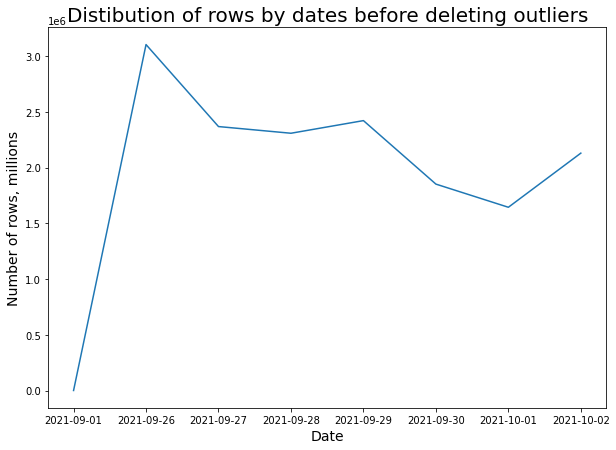

After deleting outliers:

    date_time  number_of_rows
0  2021-09-26         3102610
1  2021-09-27         2367303
2  2021-09-28         2307355
3  2021-09-29         2420588
4  2021-09-30         1851189
5  2021-10-01         1643448
6  2021-10-02         2128978


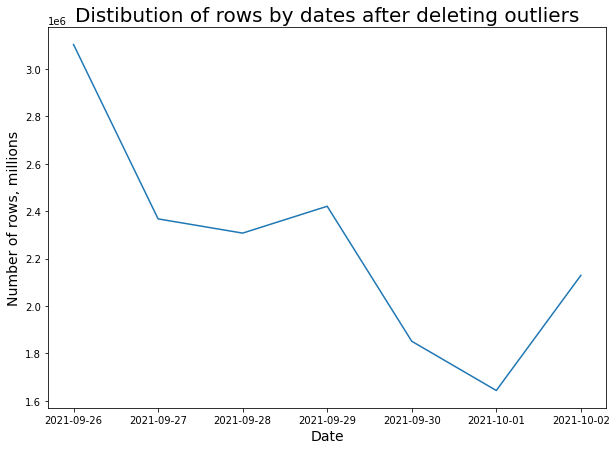

Missing values by each feature:
date_time          0
zone_id            0
banner_id          0
campaign_clicks    0
os_id              0
country_id         0
clicks             0
date_time_str      0
dtype: int64

Frequency of not click and click:
0    0.973312
1    0.026688
Name: clicks, dtype: float64


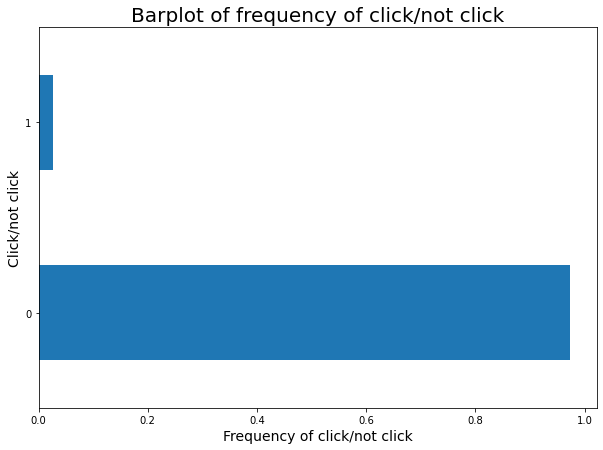

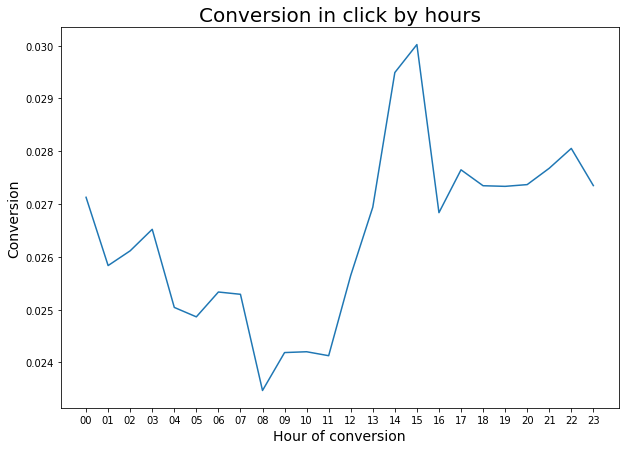

In [92]:
df = analysis(df)

## Feature transforming, engineering and encoding

Feature transforming - вытягиваем различные признаки временных рядов:
- месяц наблюдения
- неделя наблюдения
- день наблюдения
- выходной/рабочий день
- час наблюдения
- минута наблюдения
- секунда наблюдения

Feature engineering - создаем различные интеракции и кодируем предикторы при помощи OneHotEncoder'а, в частности, интеракции создаем по трем группам:
- Интеракции по фичам пользователя (ОС пользователя, страна пользователя и т.д.)
- Интеракции по календарной дате наблюдения (месяц, неделя, день)
- Интеракции по дневной дате наблюдения (час, минута, секунда)

In [93]:
df = feature_transforming(df)

In [101]:
X, y = feature_engineering(df)

100%|████████████████████████████████████████| 35/35 [2:11:37<00:00, 225.66s/it]


In [158]:
# размерность пространства признаков, после создания интераций + 
# применения OneHotEncoder'а ко всему датасету накрафтилось очень 
# много фичей: 1.3 млн признаков, на выходе большая sparse матрица
X

<15821471x1312352 sparse matrix of type '<class 'numpy.float64'>'
	with 759430608 stored elements in Compressed Sparse Row format>

## Splitting on train, test and validation

In [108]:
train_validation_test = train_validation_test_split(df, X, y)
X_train, y_train = train_validation_test[0], train_validation_test[1]
X_validation, y_validation = train_validation_test[2], train_validation_test[3]
X_test, y_test = train_validation_test[4], train_validation_test[5]

## Cross validation

In [117]:
C_cv = np.array(list(np.linspace(0.0001, 0.1, 10)) + [0.5, 1])
errors = cross_validation(
    X_train, 
    y_train, 
    X_validation, 
    y_validation, 
    X_test, 
    y_test, 
    C_cv
)

100%|██████████████████████████████████████████| 12/12 [51:19<00:00, 256.66s/it]


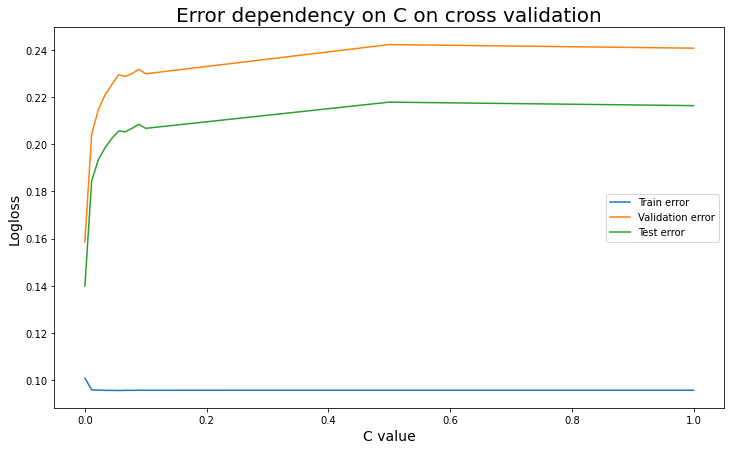


To avoid scaling problems let see log(C)


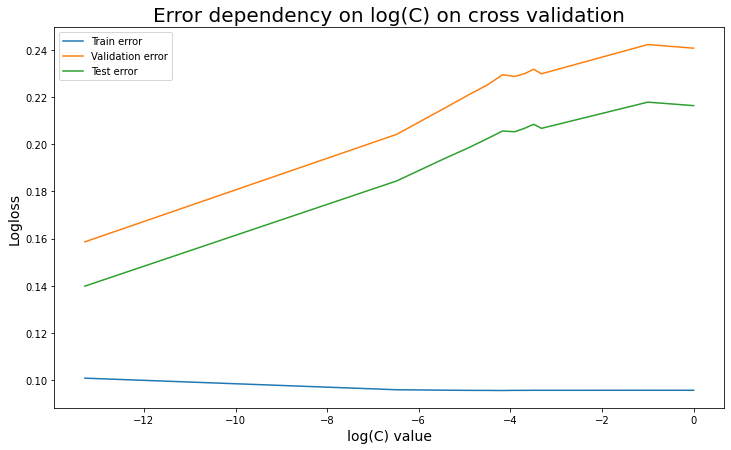

In [149]:
cross_validation_results_visualisation(errors)

## Final model evaluation

По кроссвалидации, лучший параметр регуляризации C оказался равен 0.0001, обучаем на разбиении на трейн и тест с таким параметром логистическую регрессию и смотрим на финальный логлосс скор.

In [143]:
model = create_model(errors, *train_split(df, X, y))

In [163]:
# параметры финальной модели
model.get_params()

{'C': 0.0001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 54,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [144]:
# logloss на тесте, то есть на последнем дне
log_loss(y_test, model.predict_proba(X_test))

0.13453894092288035